# Lab 3-2: Surface Energy Balance at Kettle Ponds - Full Surface Energy Balance
Written by Daniel Hogan - April, 2023.

Modified by Jessica Lundquist - April, 2023.

Modified by Eli Schwat - January 2024.

### Snow Surface Energy Balance Equation 

Consider the snow surface energy balance equation:

$$c_p^{SS} \frac{\partial T_{ss}}{\partial t} = LW_{in} - LW_{out} + SW_{in} - SW_{out} - \lambda \frac{\partial T_s}{\partial z} - H_L - H_s + E_{melt}$$

For this lab, we will ignore a few terms, including mid-winter periods, when there is no snow melt.

$$c_p^{SS} \frac{\partial T_{ss}}{\partial t} = LW_{in} - LW_{out} + SW_{in} - SW_{out} - H_L - H_s$$

In Lab 3-1, we already examined the four radiation terms. In this lab, we will estimate the remaining terms. 
We want all measurements to be in units of $W/m^2$. 
The radiation variables are already in these units.
The other variable in the dataset require conversion.

---
### Converting turbulent flux measurements into energy flux units ($W/m^2$)
Without diving too much into the details of the turbulent water vapor (latent heat) flux $H_L$ and sensible heat flux $H_s$, we note that turbulent water vapor flux is measured in units of $g/m^2/s$ and sensible heat flux is measured in units $K/m^2/s$, and are in the dataset as the following variables:

`w_h2o__3m_c` (latent heat flux)

and

`w_tc__3m_c` (sensible heat flux).

---
#### Converting turbulent latent heat flux measurements into energy flux units ($W/m^2$)

To convert `w_h2o__3m_c` (latent heat flux in $g/m^2/s$) to $W/m^2$, we will use the latent heat of sublimation (the sum of the latent heats of fusion and vaporization, $L_{sub} = 2590 J/g$).

$H_l = $ `w_h2o__3m_c` $ * L_{sub}$

and the units work out like this : $\frac{g}{m^2 s} * \frac{J}{g} = \frac{J}{m^2 s} = \frac{W}{m^2}$ (b/c 1 Watt = 1 Joule per second).

---
#### Converting turbulent sensible heat flux measurements into energy flux units ($W/m^2$)

To convert `w_tc__3m_c` (sensible heat flux in units $K m/s$) to $W/m^2$, we will use the specific heat capacity of air ($c_{p}^{air} = 1.005$ $J/K/g$) and the density of air ($\rho_{air} = 1000 g / m^3$). Note that we use the physical constants for air since it is air that is transporting heat away from the snowpack. 

$H_s = $ `w_tc__3m_c` $ * c_{p}^{air} * \rho_{air}$

and the units work out like this: $\frac{K m}{s} * \frac{J}{K g} * \frac{g}{m^3} = = \frac{W}{m^2}$

---
#### Estimate the snow surface temperature change term
To estimate the time derivative of $T_ss$, we will use a finite difference approximation, 

$$\frac{\partial T_{ss}}{\partial t} \approx \frac{\Delta T_{ss}}{\Delta t}$$

where $\Delta t$ = 30 minutes (the temporal resolution of our dataset).
We can estimate $\Delta T_{ss}$ using a forward difference approximation.
If you have not heard of "forward differencing", please check out the wikipedia page https://en.wikipedia.org/wiki/Finite_difference.

Note that, according to the energy balance equation, we also need the specific heat capacity of the snow surface, $c_{p}^{ss}$, which we will approximate as the specific heat capacity of ice, $c_{p}^{ss} \approx c_{p}^{ice} = 2.1 J/K/g$.

The units for the term $c_{p}^{ss} \frac{\Delta T_{ss}}{\Delta t}$ work out like this: $\frac{J}{K g} * \frac{K}{s} = \frac{W}{g}$

Note that this is an issue - we need to the surface temperature change term to be in units of $W/m^2$, but we have $W/g$. This is a result of the fact that we are trying to estimate the energy it takes to change the temperature of a surface, an infinitely thin layer of snow at the surface, which doesn't really exist.
To address this, say that we want to estimate the energy involved in changing the top 0.01 meters of snow. Over a 1x1 $m^2$ area, that is a 0.01 $m^3$ volume of snow. We then use the density of ice ($\rho_{ice} = 910 kg/m^3 = 9.1e^5 g/m^3$) to convert the thin layer of snow to a weight.
But we want the energy per area, so we divide by the thickness of the layer (0.01 m) and we are left with units of $m^2$. 

Formally, this transformation looks like this: 
$c_{p}^{ss} \frac{\Delta T_{ss}}{\Delta t} * \rho_{ice} * $ surface_layer_thickness

and the units work out like this: $\frac{J}{K g} * \frac{K}{s} * \frac{1e^6 g}{m^3} * m = \frac{W}{m^2}$

---

In [31]:
import xarray as xr
import numpy as np
import os 
import urllib
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

### SOS Data

In [32]:
sos_file = "../data/sos_full_dataset_30min.nc"
sos_dataset = xr.open_dataset(sos_file)

### Calculate net radiation

In [33]:
[v for v in sos_dataset.data_vars if v.startswith('Rsw')]

['Rsw_in_9m_d', 'Rsw_out_9m_d', 'Rsw_net_9m_d']

In [34]:
[v for v in sos_dataset.data_vars if v.startswith('Rlw')]

['Rlw_in_9m_d',
 'Rlw_out_9m_d',
 'Rlw_in_9m_uw',
 'Rlw_out_9m_uw',
 'Rlw_net_9m_d',
 'Rlw_net_9m_uw']

Note that we are accounting for the energy balance of the snow surface, so SW and LW radiation *away* from the snow pack are subtracted.

In [35]:
net_radiation = sos_dataset['Rsw_in_9m_d'] - sos_dataset['Rsw_out_9m_d'] + sos_dataset['Rlw_in_9m_d'] - sos_dataset['Rlw_out_9m_d']

### Calculate latent heat flux in energy units

Note that the measurement `w_h2o__3m_c` is latent heat flux *away* from the snow pack, so in terms of snowpack surface energy, positive `w_h2o__3m_c` is energy lost, and so we need to negate the measurements.

In [36]:
latent_heat_sublimation = 2590 #J/g
latent_heat_flux = sos_dataset['w_h2o__3m_c'] * latent_heat_sublimation

# negating the measurements
latent_heat_flux = - latent_heat_flux

### Calculate sensible heat flux in energy units
Same as above, we need to negate the measurements

In [37]:
specific_heat_capacity_air = 1.005 # J/K/g
air_density = 1000 # g/m^3                                       
sensible_heat_flux = sos_dataset['w_tc__3m_c'] * specific_heat_capacity_air * air_density

# negating the measurements
sensible_heat_flux = - sensible_heat_flux

### Calculate snow surface temperature change in energy units

In [38]:
specific_heat_capacity_ice = 2.1 # J/K/g
density_ice = 9.1e5 #g/m^3
surface_layer_thickness = 0.01 #m

# calculate the forward difference of T_ss
delta_Tss_over_delta_t = np.gradient(
    sos_dataset['Tsurf_c'],
    30*60 # number of seconds in thirty minutes
)

# np.gradient returns a numpy array. We can create an XArray dataarray from the returned numpy array so that we can use the same plotting functions for all of our terms.
delta_Tss_over_delta_t = xr.DataArray(
    delta_Tss_over_delta_t,
    coords = sos_dataset['Tsurf_c'].coords,
    dims = sos_dataset['Tsurf_c'].dims
)
snow_surface_temp_change = delta_Tss_over_delta_t * specific_heat_capacity_ice * density_ice * surface_layer_thickness

## Plot energy balance terms for a 5 day period in April 

Look at some other time periods too. The radiometers went out a lot, but this stretch of time had good radiometer data.

Text(0, 0.5, 'Energy flux (W/m^2)')

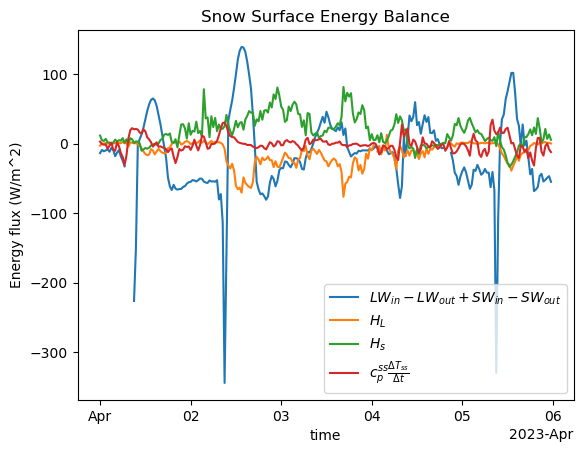

In [39]:
time_slice = slice('20230401', '20230405')
net_radiation.sel(time=time_slice).plot(label=r'$LW_{in} - LW_{out} + SW_{in} - SW_{out}$')
latent_heat_flux.sel(time=time_slice).plot(label=r'$H_L$')
sensible_heat_flux.sel(time=time_slice).plot(label=r'$H_s$')
snow_surface_temp_change.sel(time=time_slice).plot(label=r'$c_{p}^{ss} \frac{\Delta T_{ss}}{\Delta t}$')
plt.legend()
plt.title('Snow Surface Energy Balance')
plt.ylabel('Energy flux (W/m^2)')

## Calculate the average hourly daily energy balance from the entire dataset (i.e. take the average values for each term, for 1am-2am from all days).

I find this is easier to do with a Pandas Dataframe than an Xarray dataset, so I create a Pandas Dataframe with our results first.

In [40]:
# Create the dataframe with the terms we calculated. Assign the dataframe index as the timestamps.
energy_balance_df = pd.DataFrame({
        'net_radiation': net_radiation,
        'latent_heat_flux': latent_heat_flux,
        'sensible_heat_flux': sensible_heat_flux,
        'snow_surface_temp_change': snow_surface_temp_change,
    },
    index = net_radiation.time
)
energy_balance_df.head()

,net_radiation,latent_heat_flux,sensible_heat_flux,snow_surface_temp_change
2022-11-01 00:00:00,-68.235901,0.462150,1.798522,3.028704
2022-11-01 00:30:00,-67.883957,0.263518,8.952477,-3.305558
2022-11-01 01:00:00,-67.512054,1.797184,0.394793,-2.660322
2022-11-01 01:30:00,-66.782730,1.439764,7.073821,2.517603
2022-11-01 02:00:00,-66.476273,3.634344,-8.566571,0.055241


In [41]:
# Create a column representing the hour of the day
energy_balance_df['hour_of_day'] = energy_balance_df.index.hour

# Groupby the hour_of_day and take the median (instead of the mean, this will handle any outliers, which appear in the radiation data)
energy_balance_df_diurnal_average = energy_balance_df.groupby('hour_of_day').median()

In [42]:
energy_balance_df_diurnal_average

,net_radiation,latent_heat_flux,sensible_heat_flux,snow_surface_temp_change
hour_of_day,,,,
0,-47.033958,0.066211,4.794281,-1.665739
1,-42.851898,0.177739,4.826415,-1.254832
2,-40.615479,0.056037,4.340652,-1.267954
3,-38.523750,0.187343,3.317965,-1.494427
4,-40.751106,0.193451,3.180370,-1.106362
5,-39.858032,0.356504,3.584616,-0.586917
6,-34.822273,0.051772,2.867932,1.044641
7,-19.617561,-0.768515,1.418502,5.688541
8,-0.127869,-3.778184,0.651874,13.368355


Text(0, 0.5, 'Energy flux (W/m^2)')

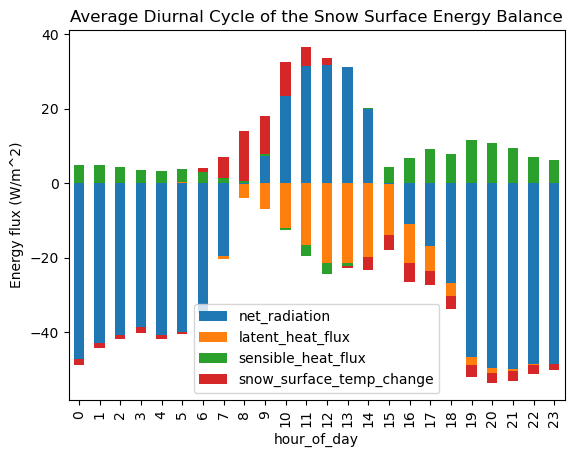

In [43]:
energy_balance_df_diurnal_average.plot.bar(stacked=True)
plt.title('Average Diurnal Cycle of the Snow Surface Energy Balance')
plt.ylabel('Energy flux (W/m^2)')

# Calculate the residual
According to our simplified energy balance equation, 

$$c_p^{SS} \frac{\partial T_{ss}}{\partial t} = LW_{in} - LW_{out} + SW_{in} - SW_{out} - H_L - H_s$$

all of our terms should balance. 

We can calculate the "Residual" moving all terms to one side of the equation (note we replace all four radiation terms with one net radiation term $R_n$)

$$0 = R_{net} - H_L - H_s - c_p^{SS} \frac{\partial T_{ss}}{\partial t}$$

The residual exists to *make* the left size equal zero,

$$0 = R_{net} - H_L - H_s - c_p^{SS} \frac{\partial T_{ss}}{\partial t} + Residual$$

therefore,

$$Residual = - R_{net} + H_L + H_s + c_p^{SS} \frac{\partial T_{ss}}{\partial t} $$

In [44]:
energy_balance_df_diurnal_average.columns

Index(['net_radiation', 'latent_heat_flux', 'sensible_heat_flux',
       'snow_surface_temp_change'],
      dtype='object')

In [45]:
energy_balance_df_diurnal_average['residual'] = (
    - energy_balance_df_diurnal_average['net_radiation'] 
    - energy_balance_df_diurnal_average['latent_heat_flux'] # we already negated latent heat flux above, so we need to un-negate it here
    + energy_balance_df_diurnal_average['sensible_heat_flux'] # we already negated sensible heat flux above, so we need to un-negate it here
    + energy_balance_df_diurnal_average['snow_surface_temp_change']
)

Text(0, 0.5, 'Energy flux (W/m^2)')

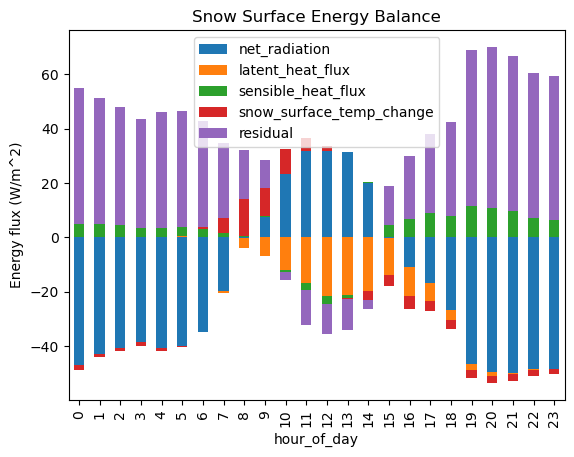

In [46]:
energy_balance_df_diurnal_average.plot.bar(stacked=True)
plt.title('Snow Surface Energy Balance')
plt.ylabel('Energy flux (W/m^2)')

Note, as we discussed in lecture, the residual is very large at night. During the day, it is smaller but still substantial.

What could be the cause of the residual here?